<a href="https://colab.research.google.com/github/Lucas-Siade/Data-Science/blob/main/Projeto%20Final/Modelo%20-%20Tend%C3%AAncia.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Bibliotecas**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

## **Funções**

### **Carregar os Dados**

In [ ]:
def carregarDados(path):
    dataset = pd.read_csv(path, sep="\t")

    dataset = dataset.drop(columns=["<SPREAD>"])
    dataset = dataset.rename(columns={
        "<DATE>":"DATE",
        "<TIME>":"TIME",
        "<OPEN>":"OPEN",
        "<CLOSE>":"CLOSE",
        "<HIGH>":"HIGH",
        "<LOW>":"LOW",
        "<TICKVOL>":"TICKVOL",
        "<VOL>":"VOL"
    })

    dataset["TIMESTAMP"] = pd.to_datetime(dataset["DATE"] + " " + dataset["TIME"], format="%Y.%m.%d %H:%M:%S")
    dataset.drop(columns=["DATE", "TIME"], inplace=True)
    dataset = dataset[["TIMESTAMP", "OPEN", "HIGH", "LOW", "CLOSE", "TICKVOL", "VOL"]]

    return dataset

### **Adicionar dias anteriores**

In [ ]:
def adicionarAnteriores(dataset, dias):
    datasetCopy = dataset.copy()

    for i in range(0, dias):
        for coluna in ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL']:
            datasetCopy[f'{coluna}_{i}'] = datasetCopy[coluna].shift(i)

    return datasetCopy

### **Classificação**

In [ ]:
def classificar(dataset):
    datasetCopy = dataset.copy()
    datasetCopy['VARIACAO'] = 'NEUTRO'

    for i in range(1, len(datasetCopy)):
        if datasetCopy.loc[i, 'CLOSE'] > datasetCopy.loc[i - 1, 'CLOSE']:
            datasetCopy.loc[i, 'VARIACAO'] = 'ALTA'
        elif datasetCopy.loc[i, 'CLOSE'] < datasetCopy.loc[i - 1, 'CLOSE']:
            datasetCopy.loc[i, 'VARIACAO'] = 'QUEDA'

    datasetCopy = datasetCopy.drop(index=0).reset_index(drop=True)

    while 'NEUTRO' in datasetCopy['VARIACAO'].values:
        for i in range(len(datasetCopy) - 1):
            if datasetCopy.loc[i, 'VARIACAO'] == 'NEUTRO':
                datasetCopy.loc[i, 'VARIACAO'] = datasetCopy.loc[i + 1, 'VARIACAO']

    return datasetCopy

### **Remover valores do dia atual**

In [ ]:
def removerValores(dataset):
    colunas = ['OPEN', 'HIGH', 'LOW', 'CLOSE', 'TICKVOL', 'VOL']

    return dataset.drop(columns=[col for col in colunas])

### **Treino do Modelo**

In [ ]:
def treinar(datasetRegLog):
    #DEFINIR VARIÁVEIS
    datasetRegLog['VARIACAO_BIN'] = datasetRegLog['VARIACAO'].map({'ALTA': 1, 'QUEDA': 0})
    colunasXRegLog = [col for col in datasetRegLog.columns if any(p in col for p in ['OPEN_', 'HIGH_', 'LOW_', 'CLOSE_', 'TICKVOL_', 'VOL_'])]

    XRegLog = datasetRegLog[colunasXRegLog]
    YRegLog = datasetRegLog['VARIACAO_BIN']

    #DIVISÃO EM TREINO E TESTE
    XRegLog_treino, XRegLog_teste, YRegLog_treino, YRegLog_teste = train_test_split(XRegLog, YRegLog, test_size=0.2, shuffle=False, random_state=42)

    #TREINO DO MODELO
    modelRegLog = LogisticRegression(max_iter=1000)
    modelRegLog.fit(XRegLog_treino, YRegLog_treino)

    #PREVISÕES
    YRegLog_pred = modelRegLog.predict(XRegLog_teste)

    return confusion_matrix(YRegLog_teste, YRegLog_pred), classification_report(YRegLog_teste,YRegLog_pred, output_dict=True)

## **Código**

In [ ]:
path = "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/Dados.csv"
dataset = carregarDados(path)

resultados = {}

for dias in range(1, 11):
    print(f"\n📊 Avaliando modelo com {dias} dias anteriores...")

    datasetNovo = dataset.copy()

    datasetNovo = adicionarAnteriores(datasetNovo, dias)
    datasetNovo = datasetNovo.dropna().reset_index(drop=True)
    datasetNovo = classificar(datasetNovo)
    datasetNovo = removerValores(datasetNovo)

    display(datasetNovo.head())

    matriz, relatorio = treinar(datasetNovo)

    print("Matriz de Confusão:")
    print(matriz)

    print("Acurácia:", relatorio['accuracy'])
    print("Precisão:", relatorio['1']['precision'])
    print("Recall:", relatorio['1']['recall'])
    print("F1-Score:", relatorio['1']['f1-score'])

    resultados[dias] = {
        "acuracia": relatorio['accuracy'],
        "precision_ALTA": relatorio['1']['precision'],
        "recall_ALTA": relatorio['1']['recall'],
        "f1_score_ALTA": relatorio['1']['f1-score'],
        "matriz_confusao": matriz
    }



📊 Avaliando modelo com 1 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,VARIACAO
0,2020-10-15 11:50:00,98570,98625,98570,98600,5483,19111,ALTA
1,2020-10-15 11:51:00,98595,98600,98535,98580,4572,17663,QUEDA
2,2020-10-15 11:52:00,98575,98620,98535,98615,3536,13143,ALTA
3,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,QUEDA
4,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,ALTA


Matriz de Confusão:
[[31597  1177]
 [  984 31995]]
Acurácia: 0.9671345794108254
Precisão: 0.9645182684191487
Recall: 0.9701628308923861
F1-Score: 0.9673323154600838

📊 Avaliando modelo com 2 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,CLOSE_1,TICKVOL_1,VOL_1,VARIACAO
0,2020-10-15 11:51:00,98595,98600,98535,98580,4572,17663,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,QUEDA
1,2020-10-15 11:52:00,98575,98620,98535,98615,3536,13143,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,ALTA
2,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,QUEDA
3,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,ALTA
4,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,QUEDA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[31925   848]
 [  599 32380]]
Acurácia: 0.9779930648497384
Precisão: 0.9744793547610449
Recall: 0.9818369265290033
F1-Score: 0.9781443049828568

📊 Avaliando modelo com 3 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,CLOSE_1,TICKVOL_1,VOL_1,OPEN_2,HIGH_2,LOW_2,CLOSE_2,TICKVOL_2,VOL_2,VARIACAO
0,2020-10-15 11:52:00,98575,98620,98535,98615,3536,13143,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,ALTA
1,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,QUEDA
2,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,ALTA
3,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,QUEDA
4,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,ALTA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[31366  1407]
 [ 1377 31602]]
Acurácia: 0.9576590826134567
Precisão: 0.9573752612923748
Recall: 0.9582461566451378
F1-Score: 0.9578105110020003

📊 Avaliando modelo com 4 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_2,TICKVOL_2,VOL_2,OPEN_3,HIGH_3,LOW_3,CLOSE_3,TICKVOL_3,VOL_3,VARIACAO
0,2020-10-15 11:53:00,98620,98625,98575,98610,3729,13702,98575.0,98620.0,98535.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,QUEDA
1,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,ALTA
2,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,QUEDA
3,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,ALTA
4,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,QUEDA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[28974  3799]
 [ 4044 28935]]
Acurácia: 0.88071845723324
Precisão: 0.8839433005437771
Recall: 0.8773765123260256
F1-Score: 0.8806476648456165

📊 Avaliando modelo com 5 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_3,TICKVOL_3,VOL_3,OPEN_4,HIGH_4,LOW_4,CLOSE_4,TICKVOL_4,VOL_4,VARIACAO
0,2020-10-15 11:54:00,98610,98655,98590,98655,5040,17128,98620.0,98625.0,98575.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,ALTA
1,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,QUEDA
2,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,ALTA
3,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,QUEDA
4,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,QUEDA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[28860  3913]
 [ 5631 27348]]
Acurácia: 0.8548485217179705
Precisão: 0.874828060522696
Recall: 0.8292549804420996
F1-Score: 0.8514321295143213

📊 Avaliando modelo com 6 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_4,TICKVOL_4,VOL_4,OPEN_5,HIGH_5,LOW_5,CLOSE_5,TICKVOL_5,VOL_5,VARIACAO
0,2020-10-15 11:55:00,98650,98665,98610,98615,4021,13669,98610.0,98655.0,98590.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,QUEDA
1,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,ALTA
2,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,QUEDA
3,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,QUEDA
4,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,ALTA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[27637  5136]
 [ 3353 29626]]
Acurácia: 0.8708936610293223
Precisão: 0.8522524595823026
Recall: 0.8983292398192789
F1-Score: 0.8746844599282562

📊 Avaliando modelo com 7 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_5,TICKVOL_5,VOL_5,OPEN_6,HIGH_6,LOW_6,CLOSE_6,TICKVOL_6,VOL_6,VARIACAO
0,2020-10-15 11:56:00,98615,98675,98585,98660,5008,17128,98650.0,98665.0,98610.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,ALTA
1,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,QUEDA
2,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,QUEDA
3,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,ALTA
4,2020-10-15 12:00:00,98675,98720,98635,98665,8265,30503,98655.0,98685.0,98630.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,QUEDA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[26407  6365]
 [ 6794 26185]]
Acurácia: 0.7998661617313805
Precisão: 0.8044546850998464
Recall: 0.7939901149216168
F1-Score: 0.7991881457064811

📊 Avaliando modelo com 8 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_6,TICKVOL_6,VOL_6,OPEN_7,HIGH_7,LOW_7,CLOSE_7,TICKVOL_7,VOL_7,VARIACAO
0,2020-10-15 11:57:00,98655,98690,98640,98660,4306,15124,98615.0,98675.0,98585.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,QUEDA
1,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,QUEDA
2,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,ALTA
3,2020-10-15 12:00:00,98675,98720,98635,98665,8265,30503,98655.0,98685.0,98630.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,QUEDA
4,2020-10-15 12:01:00,98670,98840,98635,98810,16807,59543,98675.0,98720.0,98635.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,ALTA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[25445  7327]
 [ 6760 26219]]
Acurácia: 0.785752307949689
Precisão: 0.781583497287307
Recall: 0.7950210740167986
F1-Score: 0.7882450206689214

📊 Avaliando modelo com 9 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_7,TICKVOL_7,VOL_7,OPEN_8,HIGH_8,LOW_8,CLOSE_8,TICKVOL_8,VOL_8,VARIACAO
0,2020-10-15 11:58:00,98660,98675,98630,98655,2977,11276,98655.0,98690.0,98640.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,QUEDA
1,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,ALTA
2,2020-10-15 12:00:00,98675,98720,98635,98665,8265,30503,98655.0,98685.0,98630.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,QUEDA
3,2020-10-15 12:01:00,98670,98840,98635,98810,16807,59543,98675.0,98720.0,98635.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,ALTA
4,2020-10-15 12:02:00,98810,98840,98755,98795,9926,37176,98670.0,98840.0,98635.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,QUEDA


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Matriz de Confusão:
[[25959  6813]
 [ 5006 27973]]
Acurácia: 0.82024607990753
Precisão: 0.8041453458287817
Recall: 0.848206434397647
F1-Score: 0.8255884306057699

📊 Avaliando modelo com 10 dias anteriores...


,TIMESTAMP,OPEN_0,HIGH_0,LOW_0,CLOSE_0,TICKVOL_0,VOL_0,OPEN_1,HIGH_1,LOW_1,...,CLOSE_8,TICKVOL_8,VOL_8,OPEN_9,HIGH_9,LOW_9,CLOSE_9,TICKVOL_9,VOL_9,VARIACAO
0,2020-10-15 11:59:00,98655,98685,98630,98670,2799,10529,98660.0,98675.0,98630.0,...,98580.0,4572.0,17663.0,98570.0,98625.0,98570.0,98600.0,5483.0,19111.0,ALTA
1,2020-10-15 12:00:00,98675,98720,98635,98665,8265,30503,98655.0,98685.0,98630.0,...,98615.0,3536.0,13143.0,98595.0,98600.0,98535.0,98580.0,4572.0,17663.0,QUEDA
2,2020-10-15 12:01:00,98670,98840,98635,98810,16807,59543,98675.0,98720.0,98635.0,...,98610.0,3729.0,13702.0,98575.0,98620.0,98535.0,98615.0,3536.0,13143.0,ALTA
3,2020-10-15 12:02:00,98810,98840,98755,98795,9926,37176,98670.0,98840.0,98635.0,...,98655.0,5040.0,17128.0,98620.0,98625.0,98575.0,98610.0,3729.0,13702.0,QUEDA
4,2020-10-15 12:03:00,98795,98815,98735,98800,6631,27104,98810.0,98840.0,98755.0,...,98615.0,4021.0,13669.0,98610.0,98655.0,98590.0,98655.0,5040.0,17128.0,ALTA


Matriz de Confusão:
[[26309  6463]
 [ 6748 26231]]
Acurácia: 0.7990752992349927
Precisão: 0.8023184682204686
Recall: 0.7953849419327451
F1-Score: 0.798836660423614


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


## **Resultado**

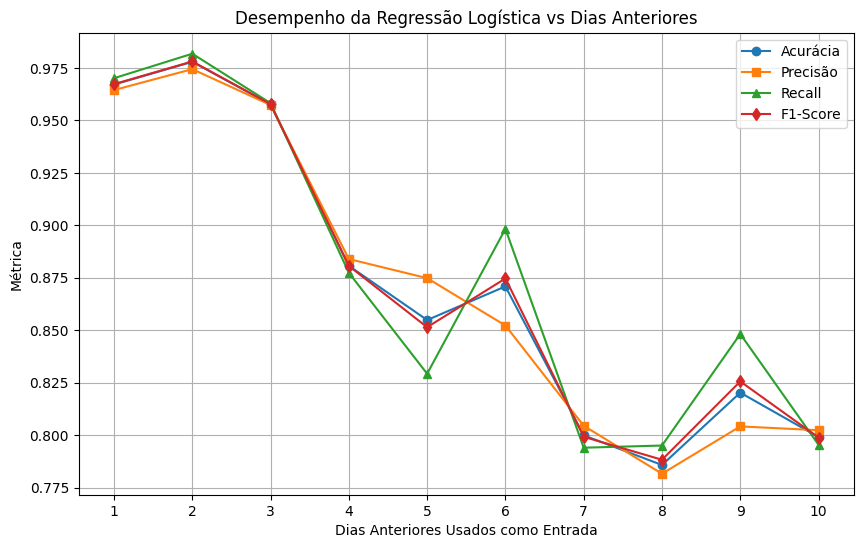

In [ ]:
resultados = pd.DataFrame.from_dict(resultados, orient='index')
resultados.reset_index(inplace=True)
resultados = resultados.rename(columns={"index": "dias_anteriores"})

plt.figure(figsize=(10, 6))

plt.plot(resultados["dias_anteriores"], resultados["acuracia"], marker='o', label="Acurácia")
plt.plot(resultados["dias_anteriores"], resultados["precision_ALTA"], marker='s', label="Precisão")
plt.plot(resultados["dias_anteriores"], resultados["recall_ALTA"], marker='^', label="Recall")
plt.plot(resultados["dias_anteriores"], resultados["f1_score_ALTA"], marker='d', label="F1-Score")

plt.title("Desempenho da Regressão Logística vs Dias Anteriores")
plt.xlabel("Dias Anteriores Usados como Entrada")
plt.ylabel("Métrica")
plt.xticks(resultados["dias_anteriores"])
plt.grid(True)
plt.legend()

plt.show()

## **Melhor Modelo**

In [ ]:
import joblib

path = "/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/Dados.csv"
datasetTend = carregarDados(path)
dias = 2

datasetTend = datasetTend.copy()
datasetTend = adicionarAnteriores(datasetTend, dias)
datasetTend = datasetTend.dropna().reset_index(drop=True)
datasetTend = classificar(datasetTend)
datasetTend = removerValores(datasetTend)

#DEFINIR VARIÁVEIS
datasetTend['VARIACAO_BIN'] = datasetTend['VARIACAO'].map({'ALTA': 1, 'QUEDA': 0})
colunasXTend = [col for col in datasetTend.columns if any(p in col for p in ['OPEN_', 'HIGH_', 'LOW_', 'CLOSE_', 'TICKVOL_', 'VOL_'])]

XTend = datasetTend[colunasXTend]
YTend = datasetTend['VARIACAO_BIN']

#DIVISÃO EM TREINO E TESTE
XTend_treino, XTend_teste, YTend_treino, YTend_teste = train_test_split(XTend, YTend, test_size=0.2, shuffle=False, random_state=42)

#TREINO DO MODELO
modelTend = LogisticRegression(max_iter=1000)
modelTend.fit(XTend_treino, YTend_treino)

modeloPath = f"/content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelTend.joblib"
joblib.dump(modelTend, modeloPath)

print(f"\n✅ Modelo salvo em: {modeloPath}")


✅ Modelo salvo em: /content/drive/MyDrive/Colab Notebooks/Data Science/Projeto Final/modelTend.joblib


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
